In [45]:
# imports
import pandas as pd
import datetime as dt
import sklearn
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('sales_data_sample.csv', encoding='latin1')

# Preprocessing and Transforming Dataset with RFM Analysis

In [47]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [48]:
# check if there are null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [49]:
# only complete orders will be considered
df['STATUS'].unique()

array(['Shipped', 'Disputed', 'In Process', 'Cancelled', 'On Hold',
       'Resolved'], dtype=object)

In [50]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [51]:
original_row_count = df.shape[0]
valid_statuses = ['Shipped', 'Resolved']

df = df[df['STATUS'].isin(valid_statuses)].copy()
new_row_count = df.shape[0]

print(f"Original rows: {original_row_count}")
print(f"Rows after filtering (keeping {valid_statuses}): {new_row_count}")
print(f"Total rows removed: {original_row_count - new_row_count}")

Original rows: 2823
Rows after filtering (keeping ['Shipped', 'Resolved']): 2664
Total rows removed: 159


In [52]:
snapshot_date = df['ORDERDATE'].max() + pd.Timedelta(days=1)

rfm_df = df.groupby('CUSTOMERNAME').agg(
    Recency=('ORDERDATE', lambda x: (snapshot_date - x.max()).days),
    Frequency=('ORDERNUMBER', 'nunique'),
    MonetaryValue=('SALES', 'sum')
).reset_index()

rfm_df.head()

,CUSTOMERNAME,Recency,Frequency,MonetaryValue
0,"AV Stores, Co.",182,3,157807.81
1,Alpha Cognac,51,3,70488.44
2,Amica Models & Co.,251,2,94117.26
3,"Anna's Decorations, Ltd",70,4,153996.13
4,Atelier graphique,174,3,24179.96


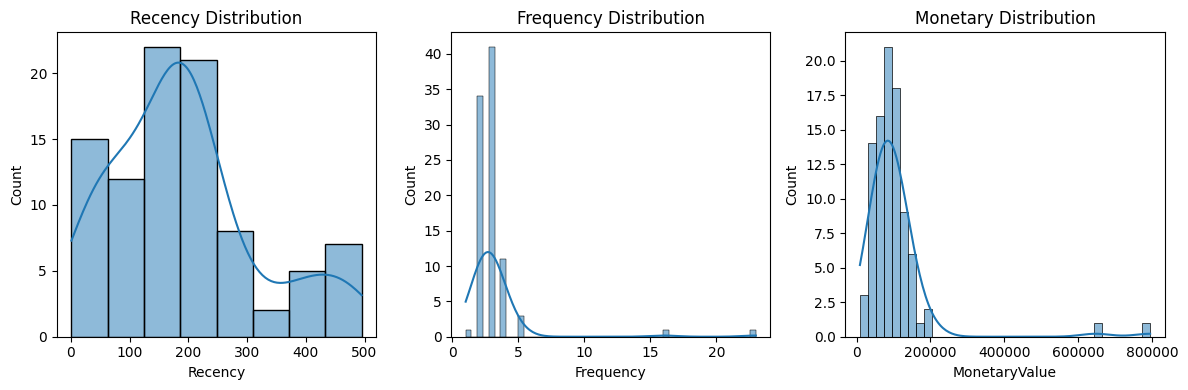

In [53]:
# distributions are left skewed
# skewed data may disturb k-means clustering
plt.figure(figsize=(12, 4))

# Plot Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')

# Plot Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Frequency Distribution')

# Plot MonetaryValue
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['MonetaryValue'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [54]:
rfm_log_df = rfm_df.copy()
rfm_log_df['Recency'] = np.log1p(rfm_log_df['Recency'])
rfm_log_df['Frequency'] = np.log1p(rfm_log_df['Frequency'])
rfm_log_df['MonetaryValue'] = np.log1p(rfm_log_df['MonetaryValue'])


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log_df[['Recency', 'Frequency', 'MonetaryValue']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'MonetaryValue'])


rfm_scaled_df.head()

,Recency,Frequency,MonetaryValue
0,0.271645,0.120570,1.070433
1,-1.060236,0.120570,-0.289512
2,0.610313,-0.774629,0.198309
3,-0.730573,0.814940,1.029175
4,0.224329,0.120570,-2.094900


# Elbow Method

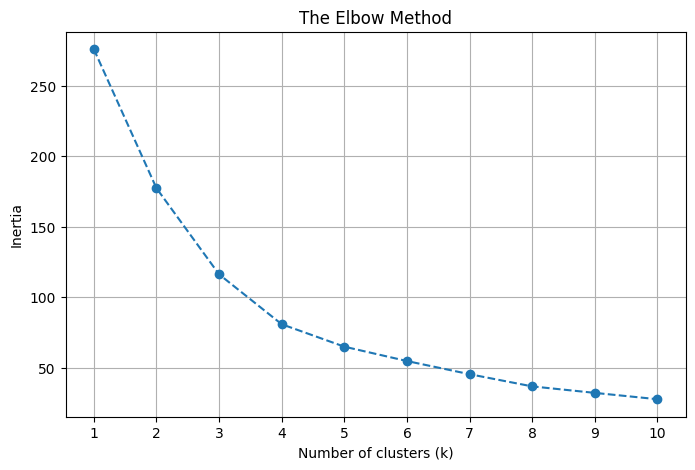

In [58]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# K-means clustering with RFM Analysis

In [62]:
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(rfm_scaled_df)

cluster_labels = kmeans.labels_
rfm_with_clusters_df = rfm_df.copy()
rfm_with_clusters_df['Cluster'] = cluster_labels
rfm_with_clusters_df.head()

,CUSTOMERNAME,Recency,Frequency,MonetaryValue,Cluster
0,"AV Stores, Co.",182,3,157807.81,0
1,Alpha Cognac,51,3,70488.44,2
2,Amica Models & Co.,251,2,94117.26,3
3,"Anna's Decorations, Ltd",70,4,153996.13,0
4,Atelier graphique,174,3,24179.96,3


In [63]:
print("\n--- Average RFM Values per Cluster ---")
cluster_analysis = rfm_with_clusters_df.groupby('Cluster').agg(
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_MonetaryValue=('MonetaryValue', 'mean'),
    Count=('CUSTOMERNAME', 'count')  # Count how many customers are in each cluster
).sort_values(by='Avg_MonetaryValue', ascending=False) # Sort by value

# Format for better readability
cluster_analysis['Avg_Recency'] = cluster_analysis['Avg_Recency'].round(1)
cluster_analysis['Avg_Frequency'] = cluster_analysis['Avg_Frequency'].round(1)
cluster_analysis['Avg_MonetaryValue'] = cluster_analysis['Avg_MonetaryValue'].round(2)

print(cluster_analysis)


--- Average RFM Values per Cluster ---
         Avg_Recency  Avg_Frequency  Avg_MonetaryValue  Count
Cluster                                                      
1               35.5           19.5          721462.26      2
0              161.8            3.1          110446.52     44
2               29.3            3.3          104452.39     12
3              292.5            2.1           55477.03     34
